2021-06-28
time : 74.45273208618164


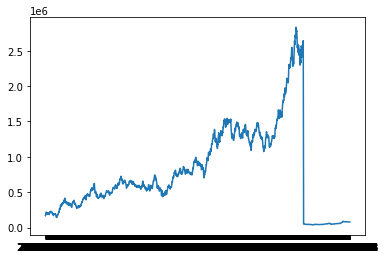

In [16]:
### import necessary modules ###
from bs4 import BeautifulSoup
import requests ; import datetime
import traceback; import pandas as pd
import time; import os
import numpy as np
import matplotlib.pyplot as plt
################################
start = time.time()
today = datetime.date.today()
print(today)
code = "005930" # code number of asset
url = "http://finance.naver.com/item/sise_day.nhn?code={code}".format(code=code)  
req=requests.get(url, headers={"User-agent" : "Mozilla/5.0"}) # call the cost of asset by request library
req.encoding = "unicode" 
req.status_code
soap = BeautifulSoup(req.text, "lxml")
table_navi = soap.find("table", class_ ="Nnavi")
td_navi = table_navi.find("td", class_="pgRR")
pg_last = td_navi.a.get("href").rsplit("&")[1]
pg_last = pg_last.split("=")[1]
pg_last = int(pg_last)

### defining basic parameters ###

dateto = datetime.datetime.strftime(datetime.datetime.today(), "%Y, %m, %d")
datefrom = datetime.datetime.strftime(datetime.datetime.today()-datetime.timedelta(days=7300), "%Y, %m, %d")
### setting the data range : 20 years ###


def parse_page(code, page):
    try:
        url = 'http://finance.naver.com/item/sise_day.nhn?code={code}&page={page}'.format(code=code, page=page)
        res = requests.get(url, headers={"User-agent" : "Mozilla/5.0"})
        _soap = BeautifulSoup(res.text, 'lxml')
        _df = pd.read_html(str(_soap.find("table")), header=0)[0]
        _df = _df.dropna()
        return _df
    except Exception as e:
        traceback.print_exc()
    return None
### parsing table from the naver finance ###

df = None
for page in range(1, pg_last+1):
    _df = parse_page(code, page)
    _df_filtered = _df[_df['날짜'] > datefrom]
    if df is None:
        df = _df_filtered
    else:
        df = pd.concat([df, _df_filtered])
    if len(_df) > len(_df_filtered):
        break
### export data from parsed table to the form of dataFrame in parameter "df" ###

cprice=df.sort_values(by="날짜", ascending=True)
cprice["5일이동평균"]= cprice["종가"].rolling(window=5,min_periods=1).mean()
cprice["5일이동평균std"] = cprice["종가"].rolling(window=5, min_periods=1).std()
### sorting data with descending date, calculate 5 days rolling average ###

path_dir = "data/{today}-crawling".format(today=today)
if not os.path.exists(path_dir):
    os.makedirs(path_dir)
path = os.path.join(path_dir, "{code}_{datefrom}_{dateto}.csv".format(code=code, datefrom=datefrom, dateto=dateto))
df.to_csv(path, index="False")
### result data saving to csv : (-)(date)(closeprice)(delta)(openprice)(localmax)(localmin)(trade)(rolling5dayavg), DataFrame###

market_date = np.array(cprice["날짜"])
close_price = np.array(cprice["종가"])
open_price = np.array(cprice["시가"]) 
rolling_avg = np.array(cprice["5일이동평균"])
rolling_std = np.array(cprice["5일이동평균std"])
###setting result as a form of array###


print("time :", time.time()-start) ### Calculate elapsed time